# Vision artificielle - TP Traitement d'images

L'objectif de ce TP est de se familiariser avec quelques techniques classiques de traitement d'images.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imsave

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 96.

# Images de test

Quelques images de test sont fournies avec ce notebook.
Vous pouvez les utiliser tout au long de la séance pour afficher et vérifier vos résultats.

Voici la liste :

In [102]:
%ls

barbara.png      mandril_color.png   test-histo1.png
cameraman.png    page.png            test-histo2.png
fingerprint.png  peppers.png         tp-traitement-images.ipynb
house.png        scotland_house.jpg
lake.png         scotland_plain.jpg


Quelques exemples :

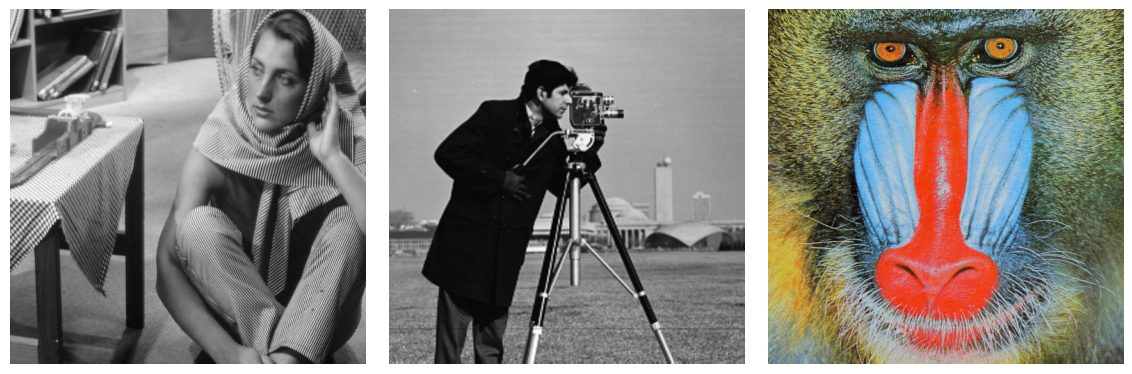

In [103]:
list_images = ['barbara.png', 'cameraman.png', 'mandril_color.png']
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(131+i)
    im = imread(list_images[i])
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()

Lorsque vous effectuez des transformations sur les images, faites attention aux types que vous manipulez.
Par exemple, si une image est en `uint8` (pixels codés sur un 1 octet), les valeurs sont limitées à l'intervalle $[0, 255]$.
N'hésitez pas à convertir si nécessaire, par exemple avec la fonction `astype` (ou à vérifier le type après une opération).

In [104]:
im = imread('barbara.png')
print(im.dtype)
topleft = im[0, 0]
im[0, 0] = -1 # Impossible en uint8
print(im[0, 0])

im = im.astype(int)
print(im.dtype)
im[0, 0] = -1 # OK
print(im[0, 0])

im[0, 0] = topleft
im = np.log(1 + im) # Conversion en float
print(im.dtype)

uint8
255
int64
-1
float64


/tmp/ipykernel_780645/914002668.py:4: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  im[0, 0] = -1 # Impossible en uint8


Au besoin, il faut également spécifier les valeurs minimales et maximales de la fonction d'affichage `imshow` :

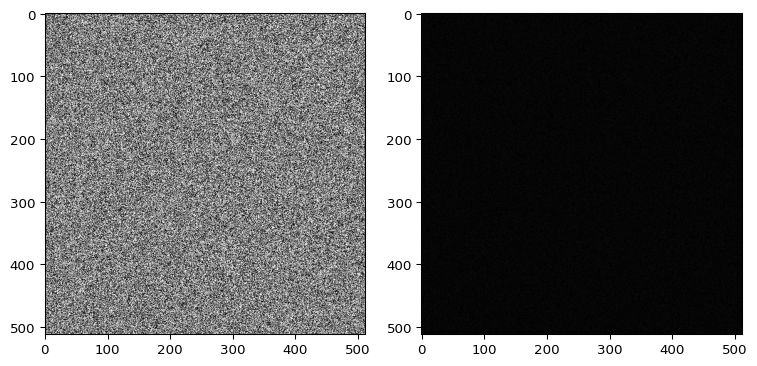

In [105]:
im = np.random.randint(0, 12, size=(512, 512), dtype=np.uint8) # Pixels aléatoires entre 0 et 64
plt.figure(figsize=(8, 4))
plt.subplot(121); plt.imshow(im) # De base, imshow remet à l'échelle les valeurs
#plt.colorbar()
plt.subplot(122); plt.imshow(im, vmin=0, vmax=255) # Spécifier vmin et vmax
#plt.colorbar()
plt.tight_layout()

# Manipulation d'histogramme

L’histogramme d'une image à niveaux de gris est défini comme l'ensemble des fréquences d’apparition des différentes valeurs des pixels.
Pour chaque niveau de gris possible (entre 0 et 255 pour une image codée sur 8 bits), on associe le nombre de pixels dans l'image qui ont cette valeur.

Généralement, on normalise les valeurs de l'histogramme par le nombre total de pixels de l'image : l'histogramme peut alors être assimilé à une distribution de probabilités.

L'histogramme nous informe sur la répartition des niveaux de gris (contraste), ainsi que sur les niveaux de gris les plus représentés (modes).
Il est cependant dépourvu de toute information spatiale.

1. Calculer et afficher l'histogramme d'une image. Tester le résultat pour le plusieurs images. Penser également à normaliser l'histogramme par le nombre de pixels dans l'image.

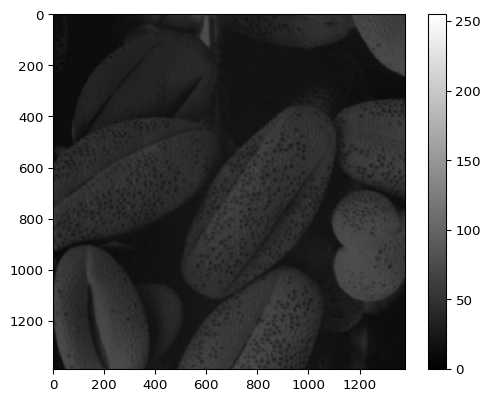

In [106]:
im = imread('test-histo1.png')
plt.imshow(im, vmin=0, vmax=255)
plt.colorbar()

2. Appliquer un étirement d'histogramme sur une image. Utiliser par exemple les images `test-histo1.png` et `test-histo2.png`.

Rappel : l'étirement d'histogramme consiste simplement à répartir les fréquences d'apparition des pixels sur toute la largeur de l'histogramme.

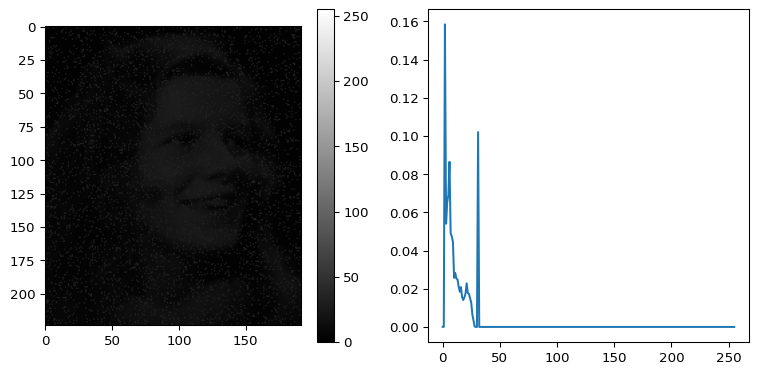

In [107]:
im = imread('test-histo2.png')

def equal(x, x_, eps=1e-6):
    return True if np.abs(x-x_) < eps else False


def histogram(im, eps=1e-6):
    h = np.zeros(256)
    for i in range(256):
        h[i] = np.sum(np.abs(im - i) < eps) / im.size
    return h 


hist = histogram(im)
assert np.sum(hist) == 1

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(im, vmin=0, vmax=255)
plt.colorbar()
plt.subplot(122)
plt.plot(hist)
plt.tight_layout()





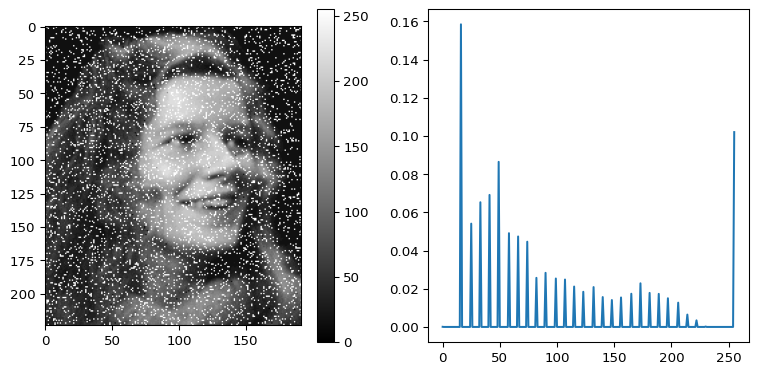

In [108]:
stretch_im = (im - im.min()) / (im.max() - im.min()) * 255

stretch_hist = histogram(stretch_im, eps=0.5)
assert np.sum(stretch_hist) == 1

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(stretch_im, vmin=0, vmax=255)
plt.colorbar()
plt.subplot(122)
plt.plot(stretch_hist)
plt.tight_layout()

3. Appliquer une égalisation d'histogramme sur une image. Utiliser par exemple les images `test-histo1.png` et `test-histo2.png`.

Rappel : les pixels de valeur $k$ auront pour nouvelle valeur $255 \times C(k)$ où $C(k) = \sum_0^k H(k)$

2
40.42480468749999


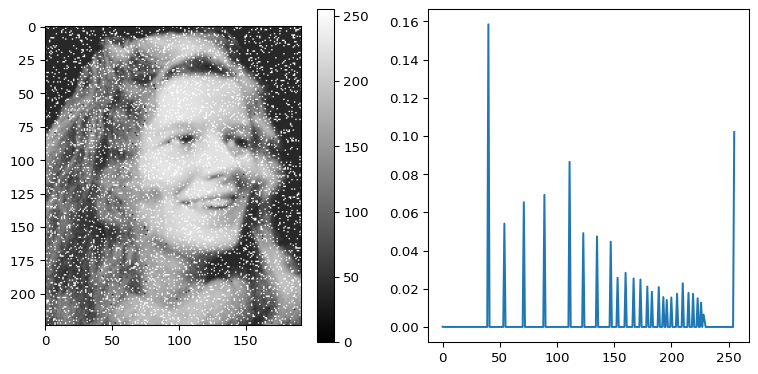

In [109]:
# C = np.cumsum(hist)
C = np.zeros(256)
for k in range(1, 256):
    C[k] = C[k-1] + hist[k]


egal_im = C[im] * 255

# print(im[0, 0])
# print(egal_im[0, 0]) 

egal_hist = histogram(egal_im, eps=0.5)

assert np.sum(egal_hist) == 1

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(egal_im, vmin=0, vmax=255)
plt.colorbar()
plt.subplot(122)
plt.plot(egal_hist)
plt.tight_layout()


4. Appliquer des opérations de binarisation par seuillage à différents niveaux. Utiliser par exemple les images `fingerprint.png` et `page.png`. Tester la méthode d'Otsu dans la librairie `skimage` pour déterminer automatiquement un seuil.

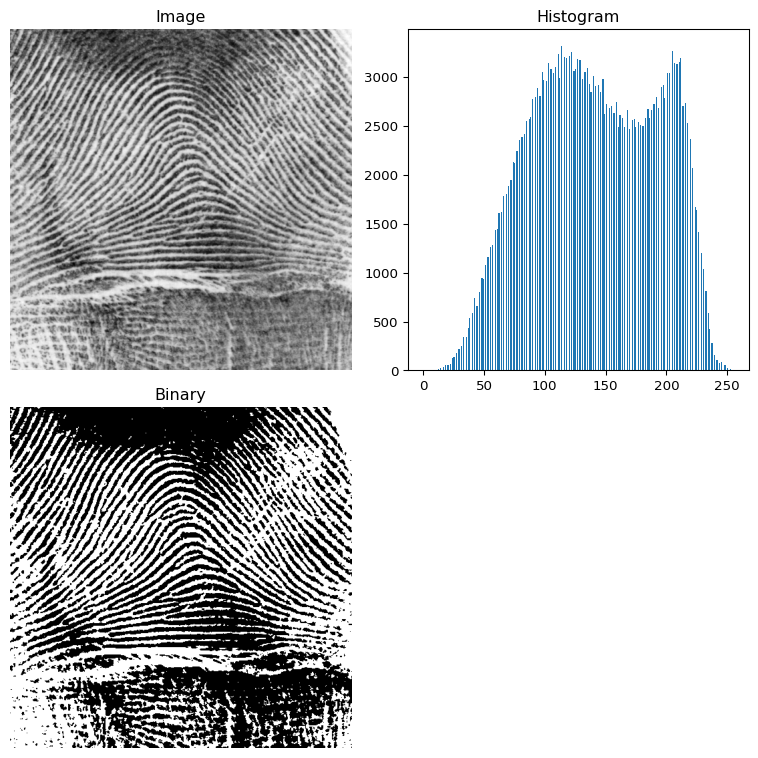

In [120]:
from skimage.filters import threshold_otsu


img = imread('fingerprint.png')
thresh = threshold_otsu(img)
binary = img > thresh

# plotting images and their histograms
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(img)
plt.axis('off')
plt.title('Image')
plt.subplot(222)
plt.hist(img.ravel(), bins=256)
plt.title('Histogram')
plt.subplot(223)
plt.imshow(binary)
plt.axis('off')
plt.title('Binary')
plt.tight_layout()


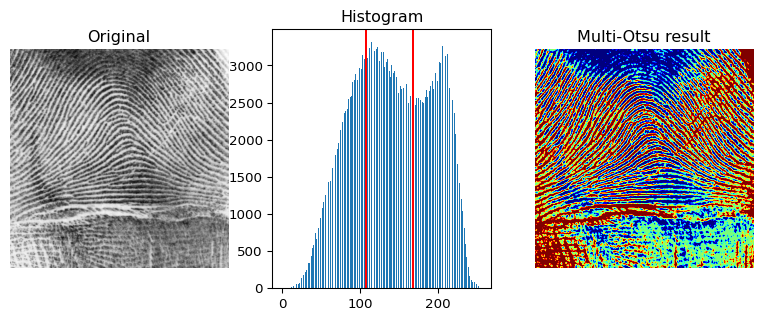

In [118]:
from skimage.filters import threshold_multiotsu

image = img

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()


# Filtrage spatial par convolution

1. Coder une fonction permettant de réaliser une convolution par un filtre de taille impaire.

In [122]:
def conv(kernel, im, aggregate=np.sum, padding=0, stride=1):
    h, w = im.shape
    kh, kw = kernel.shape
    
    if padding > 0:
        im = np.pad(im, ((padding, padding), (padding, padding)), mode='constant')
        h, w = im.shape
        
    out_h = (h - kh + 2 * padding) // stride + 1 # (W-k+2p)/s + 1
    out_w = (w - kw + 2 * padding) // stride + 1 
    out = np.zeros((out_h, out_w))
    
    for i in range(0, h - kh + 1, stride):
        for j in range(0, w - kw + 1, stride):
            out[i // stride, j // stride] = aggregate(kernel * im[i:i + kh, j:j + kw])
    return out

2. Utiliser cette fonction pour appliquer un filtre moyenneur et un filtre gaussien. Observer les résultats pour différentes images.

In [126]:
def mean_kernel(dim):
    return (1/dim**2) * np.ones((dim,dim)) 

def gaussian_kernel(sigma):
    mat = np.ones((sigma, sigma))
    for i in range(sigma):
        for j in range(sigma):
            mat[i, j] = np.exp(-(i**2 + j**2) / (2 * sigma**2))
    return mat

gauss_k = gaussian_kernel(6)
print(gauss_k)


[[1.         0.98620712 0.94595947 0.8824969  0.8007374  0.70664828]
 [0.98620712 0.97260448 0.93291196 0.87032473 0.78969293 0.69690156]
 [0.94595947 0.93291196 0.89483932 0.8348063  0.75746513 0.66846063]
 [0.8824969  0.87032473 0.8348063  0.77880078 0.70664828 0.62361492]
 [0.8007374  0.78969293 0.75746513 0.70664828 0.64118039 0.56583971]
 [0.70664828 0.69690156 0.66846063 0.62361492 0.56583971 0.49935179]]


Le filtre médian est un filtre non linéaire qui consiste à remplacer la valeur de chaque pixel par la valeur médiane de son voisinage.

3. Appliquer un filtre médian sur l'image

# Détection de contours

1. Appliquer les filtres de Prewitt et de Sobel sur des images de test et afficher les images du gradient horizontal et vertical.

2. Calculer l'intensité du gradient et appliquer différents seuillages pour binariser la carte de contours.